In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [6]:

from google.colab import files
src = list(files.upload().values())[0]

Saving clr_callback.py to clr_callback (1).py


In [7]:
open('clr_callback.py','wb').write(src)
import clr_callback

In [8]:
from google.colab import files
src = list(files.upload().values())[0]

Saving learningratefinder.py to learningratefinder.py


In [9]:
open('learningratefinder.py','wb').write(src)
import learningratefinder

In [11]:
from google.colab import files
src = list(files.upload().values())[0]

Saving config.py to config.py


In [12]:
open('config.py','wb').write(src)
import config

In [10]:
# set the matplotlib backend so figures can be saved in the background
from google.colab import files
import matplotlib
matplotlib.use("Agg")
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import pandas as pd
import os
import shutil
import random
from shutil import copyfile
from clr_callback import CyclicLR
from learningratefinder import LearningRateFinder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import argparse
import cv2
import sys
import keras
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [13]:
train_data_dir = "/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer/training/"
validation_data_dir ="/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer/validation/"
# build the DenseNet201 network
#include_top=False means that we want to ignore the fully connected layer on the top and get straight to the convolutions
pre_trained_model = tf.keras.applications.DenseNet201(input_shape=(150,150,3),weights='imagenet', include_top=False)
print('Model loaded.')
pre_trained_model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model loaded.
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn

In [14]:
TRAINING_DIR = "/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer/training/"
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    color_mode="rgb",
    batch_size=128,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle=True
)

VALIDATION_DIR = "/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer/validation/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    color_mode="rgb",
    batch_size=128,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle=False
)

# Calculate the number of training and validation steps
train_steps = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

Found 9010 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained_model.layers))

# Freeze all the layers
for layer in pre_trained_model.layers:
  layer.trainable =  True


last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape: ', last_layer.output_shape)
last_output= last_layer.output

Number of layers in the base model:  707
last layer output shape:  (None, 4, 4, 1920)


In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (7, activation='softmax')(x)

In [17]:
from itertools import tee
from sklearn import metrics

from tensorflow.keras.callbacks import *

class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # duplicate generator to make sure y_true and y_pred are calculated from the same observations
        gen_1 =self.validation_generator
        gen_2=self.validation_generator
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        f1 = metrics.f1_score(y_true, y_pred, average='weighted')
        precision = metrics.precision_score(y_true, y_pred, average='weighted')
        recall = metrics.recall_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)
        print(f" - val_f1_score: {f1:.5f} - val_precision: {precision:.5f} - val_recall: {recall:.5f} ")
        return

In [18]:
# initialize the optimizer and model
print("[INFO] compiling model...")

# add the model on top of the convolutional base
model = Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.summary()
model.compile(optimizer=optimizer, loss="categorical_crossentropy")

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv3_block1_1_bn (BatchNo  (None, 19, 19, 128)          512       ['conv3_block1_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 19, 19, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 19, 19, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

In [15]:
LRFIND_PLOT_PATH = os.path.sep.join(["/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer", "lrfind_plots.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer", "training_plots.png"])
CLR_PLOT_PATH = os.path.sep.join(["/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer", "clr_plots.png"])

In [16]:
# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
# initialize the learning rate finder and then train with learning
# rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(train_generator, 1e-10, 1e+1, stepsPerEpoch=train_steps, batchSize=train_generator.batch_size)

# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()
plt.savefig(LRFIND_PLOT_PATH)

# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")
sys.exit(0)

[INFO] finding learning rate...


/content/learningratefinder.py:137: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


Epoch 1/10
70/70 [==============================] - 3533s 50s/step - loss: 2.5904
Epoch 2/10
70/70 [==============================] - 119s 2s/step - loss: 2.6520
Epoch 3/10
70/70 [==============================] - 119s 2s/step - loss: 2.5041
Epoch 4/10
70/70 [==============================] - 119s 2s/step - loss: 1.9078
Epoch 5/10
70/70 [==============================] - 118s 2s/step - loss: 1.3116
Epoch 6/10
70/70 [==============================] - 118s 2s/step - loss: 0.8520
Epoch 7/10
70/70 [==============================] - 118s 2s/step - loss: 0.6634
Epoch 8/10
70/70 [==============================] - 118s 2s/step - loss: 2.3567
Epoch 9/10
70/70 [==============================] - 28s 369ms/step - loss: 10.6101
[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


SystemExit: 0

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [41]:
os.mkdir("/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancer/Checkpointsx_file_exp_range")
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancers/Checkpointsx_file_exp_range/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [42]:
# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = config.STEP_SIZE * 124
clr = CyclicLR(
	mode=config.CLR_METHOD,
	base_lr=0.000001,
	max_lr=0.001,
	step_size=stepSize)

In [44]:
from sklearn.utils import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Create a dictionary mapping class indices to class weights
class_weight_dict = dict(enumerate(class_weights))

# Continue training
initial_epochs = 45
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_steps,
    epochs=initial_epochs,
    validation_steps=validation_steps,
    callbacks=[clr, cp_callback],
    class_weight=class_weight_dict,
    initial_epoch=39,
    verbose=1
)

Epoch 40/45
70/70 [==============================] - ETA: 0s - loss: 0.6940
Epoch 40: saving model to /content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancers/Checkpointsx_file_exp_range/cp.ckpt
70/70 [==============================] - 140s 2s/step - loss: 0.6940 - val_loss: 0.8626
Epoch 41/45
70/70 [==============================] - ETA: 0s - loss: 0.4820
Epoch 41: saving model to /content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancers/Checkpointsx_file_exp_range/cp.ckpt
70/70 [==============================] - 129s 2s/step - loss: 0.4820 - val_loss: 0.7419
Epoch 42/45
70/70 [==============================] - ETA: 0s - loss: 0.3992
Epoch 42: saving model to /content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancers/Checkpointsx_file_exp_range/cp.ckpt
70/70 [==============================] - 128s 2s/step - loss: 0.3992 - val_loss: 0.6755
Epoch 43/45
70/70 [==============================] - ETA: 0s - loss: 0.4033
Epoch 43: saving model to /content/drive/M

In [21]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/Classification/Skin_Cancers/Checkpointsx_file_exp_range/cp.ckpt")


In [22]:
from sklearn.metrics import classification_report

# Generate true labels from the entire validation set
y_true = validation_generator.classes

# Generate predictions using the model on the entire validation set
y_pred_proba = model.predict(validation_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_proba, axis=1)

target_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Print the classification report
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

8/8 [==============================] - 199s 28s/step
              precision    recall  f1-score   support

       AKIEC       0.53      0.64      0.58        33
         BCC       0.58      0.60      0.59        52
         BKL       0.45      0.69      0.55       110
          DF       0.57      0.67      0.62        12
         MEL       0.35      0.79      0.49       112
          NV       0.96      0.66      0.78       671
        VASC       0.83      1.00      0.91        15

    accuracy                           0.68      1005
   macro avg       0.61      0.72      0.64      1005
weighted avg       0.80      0.68      0.71      1005



In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
# Generate true labels from the entire validation set
y_true = validation_generator.classes

# Generate predictions using the model on the entire validation set
y_pred_proba = model.predict(validation_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_proba, axis=1)
# Class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Iterate over classes
for i, class_name in enumerate(class_names):
    # Filter true and predicted labels for the current class
    class_true = (y_true == i)
    class_pred = (y_pred == i)

    # Calculate metrics
    precision = precision_score(class_true, class_pred)
    recall = recall_score(class_true, class_pred)
    f1 = f1_score(class_true, class_pred)
    auprc = average_precision_score(class_true, y_pred_proba[:, i])

    # Print metrics
    print(f"{class_name} precision: {precision:.3f}, recall: {recall:.3f}, f1-score: {f1:.3f}, AUPRC: {auprc:.3f}")

8/8 [==============================] - 8s 1s/step
AKIEC precision: 0.525, recall: 0.636, f1-score: 0.575, AUPRC: 0.634
BCC precision: 0.585, recall: 0.596, f1-score: 0.590, AUPRC: 0.551
BKL precision: 0.452, recall: 0.691, f1-score: 0.547, AUPRC: 0.644
DF precision: 0.571, recall: 0.667, f1-score: 0.615, AUPRC: 0.674
MEL precision: 0.355, recall: 0.786, f1-score: 0.489, AUPRC: 0.572
NV precision: 0.959, recall: 0.663, f1-score: 0.784, AUPRC: 0.958
VASC precision: 0.833, recall: 1.000, f1-score: 0.909, AUPRC: 0.987


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

# Generate true labels from the entire validation set
y_true = validation_generator.classes

# Generate predictions using the model on the entire validation set
y_pred_proba = model.predict(validation_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# Class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Calculate overall metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
balanced_accuracy_overall = balanced_accuracy_score(y_true, y_pred)

# Print overall metrics
print(f"Overall precision (macro): {precision_macro:.3f}")
print(f"Overall recall (macro): {recall_macro:.3f}")
print(f"Overall f1-score (macro): {f1_macro:.3f}")
print(f"Overall balanced accuracy: {balanced_accuracy_overall:.3f}")

# Iterate over classes
for i, class_name in enumerate(class_names):
    # Filter true and predicted labels for the current class
    class_true = (y_true == i)
    class_pred = (y_pred == i)

    # Calculate metrics
    precision = precision_score(class_true, class_pred)
    recall = recall_score(class_true, class_pred)
    f1 = f1_score(class_true, class_pred)

    # Print metrics
    print(f"{class_name} precision: {precision:.3f}, recall: {recall:.3f}, f1-score: {f1:.3f}")

8/8 [==============================] - 8s 1s/step
Overall precision (macro): 0.612
Overall recall (macro): 0.720
Overall f1-score (macro): 0.644
Overall balanced accuracy: 0.720
AKIEC precision: 0.525, recall: 0.636, f1-score: 0.575
BCC precision: 0.585, recall: 0.596, f1-score: 0.590
BKL precision: 0.452, recall: 0.691, f1-score: 0.547
DF precision: 0.571, recall: 0.667, f1-score: 0.615
MEL precision: 0.355, recall: 0.786, f1-score: 0.489
NV precision: 0.959, recall: 0.663, f1-score: 0.784
VASC precision: 0.833, recall: 1.000, f1-score: 0.909


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

# Generate true labels from the entire validation set
y_true = validation_generator.classes

# Generate predictions using the model on the entire validation set
y_pred_proba = model.predict(validation_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# Class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Calculate overall metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
balanced_accuracy_overall = balanced_accuracy_score(y_true, y_pred)

# Print overall metrics
print(f"Overall precision (macro): {precision_macro:.3f}")
print(f"Overall recall (macro): {recall_macro:.3f}")
print(f"Overall f1-score (macro): {f1_macro:.3f}")
print(f"Overall balanced accuracy: {balanced_accuracy_overall:.3f}")

# Iterate over classes
for i, class_name in enumerate(class_names):
    # Filter true and predicted labels for the current class
    class_true = (y_true == i)
    class_pred = (y_pred == i)

    # Calculate metrics
    precision = precision_score(class_true, class_pred)
    recall = recall_score(class_true, class_pred)
    f1 = f1_score(class_true, class_pred)

    # Print metrics
    print(f"{class_name} precision: {precision:.3f}, recall: {recall:.3f}, f1-score: {f1:.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot precision, recall, and F1-score for each class
metrics = {'Precision': precision_score(y_true, y_pred, average=None),
           'Recall': recall_score(y_true, y_pred, average=None),
           'F1-score': f1_score(y_true, y_pred, average=None)}

plt.figure(figsize=(10, 6))
for i, metric_name in enumerate(metrics.keys()):
    plt.subplot(1, 3, i+1)
    plt.bar(class_names, metrics[metric_name])
    plt.ylim(0, 1)
    plt.xlabel('Class')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} per Class')
plt.tight_layout()
plt.show()

8/8 [==============================] - 8s 1s/step
Overall precision (macro): 0.612
Overall recall (macro): 0.720
Overall f1-score (macro): 0.644
Overall balanced accuracy: 0.720
AKIEC precision: 0.525, recall: 0.636, f1-score: 0.575
BCC precision: 0.585, recall: 0.596, f1-score: 0.590
BKL precision: 0.452, recall: 0.691, f1-score: 0.547
DF precision: 0.571, recall: 0.667, f1-score: 0.615
MEL precision: 0.355, recall: 0.786, f1-score: 0.489
NV precision: 0.959, recall: 0.663, f1-score: 0.784
VASC precision: 0.833, recall: 1.000, f1-score: 0.909


In [31]:
%matplotlib inline

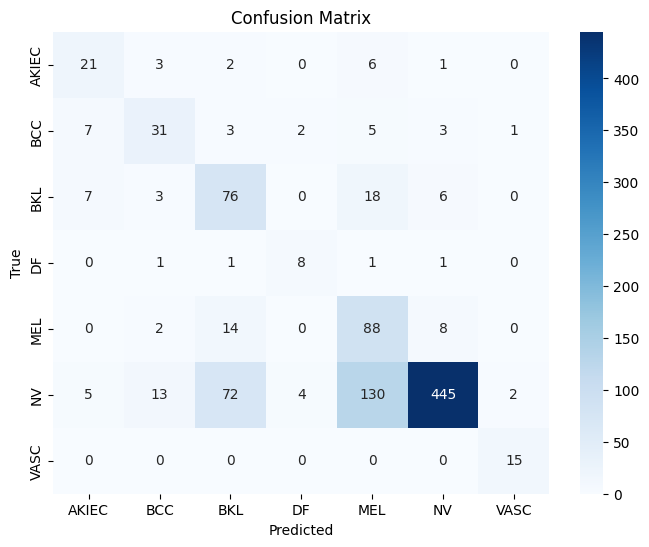

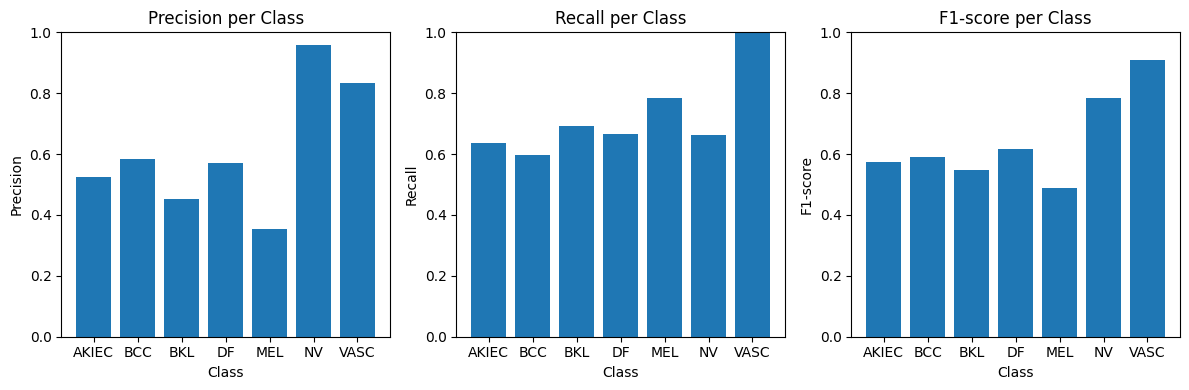

In [33]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot precision, recall, and F1-score for each class
metrics = {'Precision': precision_score(y_true, y_pred, average=None),
           'Recall': recall_score(y_true, y_pred, average=None),
           'F1-score': f1_score(y_true, y_pred, average=None)}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, metric_name in enumerate(metrics.keys()):
    axes[i].bar(class_names, metrics[metric_name])
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(metric_name)
    axes[i].set_title(f'{metric_name} per Class')
plt.tight_layout()
plt.show()